In [2]:
import io
from pathlib import Path 
import zipfile

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

figsize(8, 8)

In [3]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [5]:
def load_and_aggregate_truefx(filepaths, timeframe='1h'):
    dfs = []
    for file in tqdm(filepaths):
        df = read_and_parse_truefx(file)
        df = df.resample(timeframe).last().dropna()
        dfs.append(df)
    return pd.concat(dfs)

In [9]:
files = list(datapath.iterdir())
files.sort()
print(len(files))

trn_df = load_and_aggregate_truefx(files[:50], '1h')
tst_df = load_and_aggregate_truefx(files[50: 60], '1h')

125


length:  25183 
                          bid      ask
timestamp                            
2009-05-01 00:00:00  146.130  146.169
2009-05-01 01:00:00  145.952  146.000
2009-05-01 02:00:00  146.120  146.173
2009-05-01 03:00:00  146.110  146.144
2009-05-01 04:00:00  145.910  145.984
length:  5080 
                          bid      ask
timestamp                            
2013-07-01 00:00:00  151.082  151.189
2013-07-01 01:00:00  151.084  151.107
2013-07-01 02:00:00  151.045  151.091
2013-07-01 03:00:00  151.069  151.092
2013-07-01 04:00:00  151.215  151.253


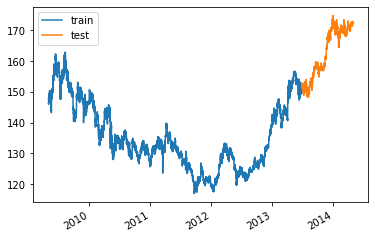

In [12]:
# %matplotlib notebook
%matplotlib inline
print('length: ', len(trn_df), '\n', trn_df.head())
print('length: ', len(tst_df), '\n', tst_df.head())
fig, ax = plt.subplots()
ax.plot(trn_df.mean(axis=1), label='train')
ax.plot(tst_df.mean(axis=1), label='test')
ax.legend()
fig.autofmt_xdate()

In [13]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.mean(axis=1)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.df[idx].to_numpy()

In [14]:
class FixedWindow(torch.utils.data.Dataset):
    def __init__(self, df, window_length):
        self.data = df.mean(axis=1).to_numpy().astype(np.float32)
#         self.data = df['C'].to_numpy().astype(np.float32)
        self.k = window_length
    def __len__(self):
        return len(self.data) - self.k
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            idx = slice(idx.start+self.k, idx.stop+self.k)
        else:
            idx = idx + self.k
        data = self.data[idx - self.k: idx]
        label = 0
        if random() < 0.5:
            data = data[::-1]
            label = 1
        return data, label

In [ ]:
class AE_CNN(nn.Module):
    """
    """
    def __init__(self, input_size, encoder_channels,
                 encoded_size, d_fc, decoder_channels,
                 dropout=0.1):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        self.d_fc = d_fc
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()
        bias = False
        
        encoder_channels = [1] + encoder_channels
        layers=[]
        for i in range(1, len(encoder_channels)):
            layers.append(nn.Conv1d(encoder_channels[i-1], 
                                    encoder_channels[i],
                                    5, bias=bias))
            layers.append(self.act)
            
        self.encoder_conv = nn.Sequential(*layers)
        
        out_sz = calc_conv_out_shape(input_size, layers)[0]
        self.encoder_fc = nn.Linear(out_sz*encoder_channels[-1],
                                    encoded_size, bias=bias)
        
        decoder_channels = [d_fc] + decoder_channels
        layers=[]
        for i in range(1, len(decoder_channels)):
            layers.append(nn.ConvTranspose1d(decoder_channels[i-1],
                                             decoder_channels[i], 
                                             5, bias=bias))
            layers.append(self.act)
            
        self.decoder_conv = nn.Sequential(
            *layers, nn.ConvTranspose1d(decoder_channels[-1], 1, 5, bias=bias))
        
        # decoder_fc is earlier in the call graph
        # but decoder_conv output is used to adaptively determine dec_sz
        # so is intialized after decoder_conv
        dec_sz = out_sz // 2
        dummy_input = torch.randn(1, d_fc, dec_sz)
        while self.decoder_conv(dummy_input).shape[-1] < input_size:
            dec_sz += 1
            dummy_input = torch.randn(1, d_fc, dec_sz)
        self.decoder_fc = nn.Linear(encoded_size, d_fc*dec_sz, bias=bias)
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x = (x-mean) / std
        x = x[..., None].transpose(1, -1)
        x = self.encoder_conv(x).reshape(x.shape[0], -1)
        x = self.act(self.encoder_fc(x))
        x = self.act(self.decoder_fc(x))
        x = self.dropout(x.reshape(x.shape[0], self.d_fc, -1))
        x = self.decoder_conv(x)[:, 0, :]        
        return mean + (x * std)

In [241]:
def model_size(model):
     return reduce(lambda x,y:x+y,
                   [reduce(lambda x,y:x+y, p.shape)
                    for p in model.parameters()])

In [242]:
def trainer(model, dataloader, device, lr=1e-3):
#     loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print_freq = max(len(dataloader) // 100, 100)
    for i, (x, label) in enumerate(iter(dataloader)):
        opt.zero_grad()
        x = x.to(device)
        y = x
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
        _loss = loss.detach().item()
        yield _loss
        if i % print_freq == 0:
            print(_loss, end='\r', flush=True)
        
        
@torch.no_grad()
def test(model, dataloader, device):
    loss_fn = nn.MSELoss()
    losses = []
    xs = []
    preds = []
    for i, (x, label) in enumerate(iter(dataloader)):
        x = x.to(device)
        y = x
        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss.detach().item())
        xs.append(x.cpu().numpy())
        preds.append(pred.cpu().numpy())
    return {'loss': losses, 'x': xs, 'pred': preds}
        

In [243]:
def show_performance(metrics):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    axs = ax.flatten()
    for i, _ax in enumerate(axs):
        _ax.plot(metrics['x'][0][i], label='x open')
        _ax.plot(metrics['pred'][0][i], label='pred open')
        _ax.legend()
    return fig, ax


In [253]:
window_size = 64
batch_size = 128
d_model = 32
d_fc = 256
encoded_size = 8

trn_dset = FixedWindow(trn_df, window_size)
tst_dset = FixedWindow(tst_df, window_size)
trnloader = torch.utils.data.DataLoader(trn_dset, batch_size=batch_size, shuffle=True)
tstloader = torch.utils.data.DataLoader(tst_dset, batch_size=batch_size, shuffle=True)

# model = AE_MLP(input_size=window_size, encoded_size=16, d_model=64, n_encoding_layers=1).to(device)
model = AE_CNN_SYMM(input_size=window_size, encoded_size=window_size//8,
                    d_model=d_model, d_fc=d_fc, n_encoding_layers=1).to(device)
# model = AE_CNN_ASYMM(input_size=64, encoded_size=32, d_model=32, n_encoding_layers=4).to(device)
print(model_size(model))

16582


In [255]:
# Test forward pass

x = next(iter(trnloader)).to(device)
pred = model(x)

assert x.shape == pred.shape 

In [256]:
losses = []

In [ ]:
epochs = 100

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
for i in tqdm(range(epochs)):
    train_loop = iter(trainer(model, trnloader, device))
    for loss in train_loop:
        losses.append(loss)
    

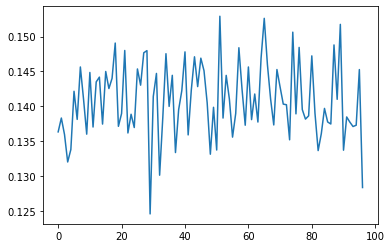

In [258]:
plt.plot(losses[-len(trnloader)+100:])

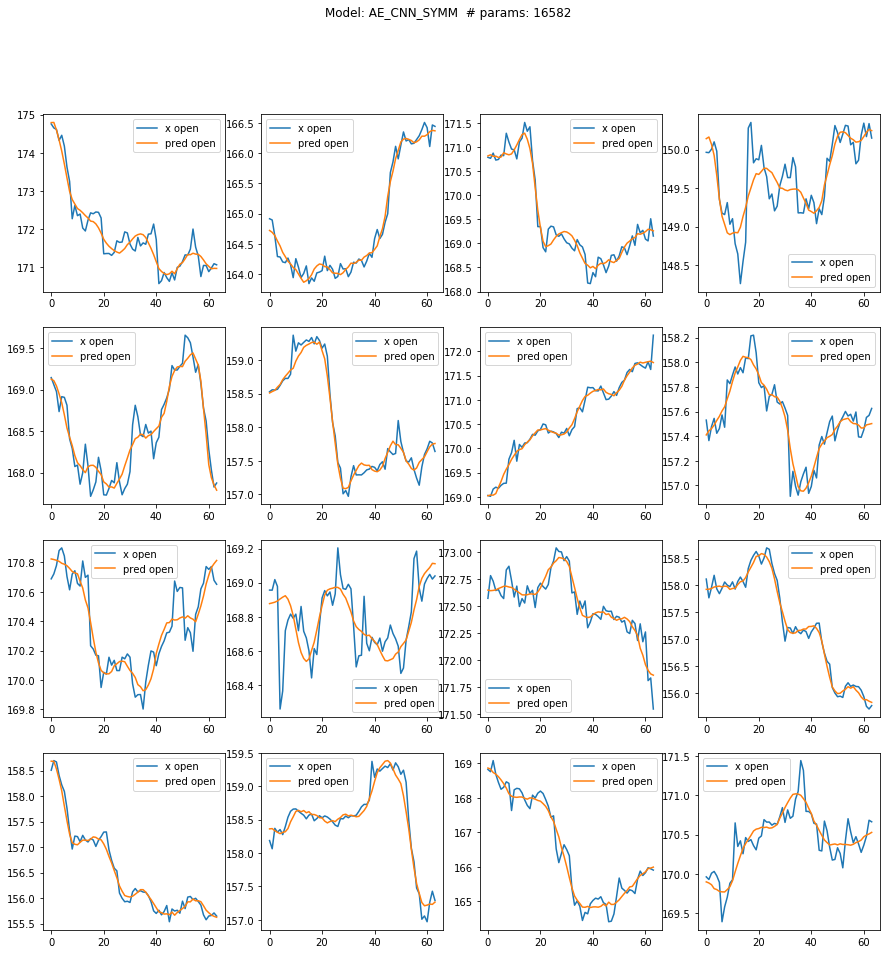

In [259]:
metrics = test(model, tstloader, device)
fig, ax = show_performance(metrics)
_ = fig.suptitle(f'Model: {type(model).__name__}  # params: {model_size(model)}')

1